## RLHF (Reinforcement Learning with Human Feedback) - from scratch <br><br>

Inspired by the diy "min" versions of AI models, this is a bare bones implementation of applying RLFH to align a language model with human preferences.<br>
The focus is on demonstrating key concepts involved in the training of large language models<br>

This skips the supervised fine-tuning step typically used in LLMS.

There are 4 main parts:

- Part 1: Language model to generate english words
- Part 2: Train a reward model on human preferences (generate short nouns)
- Part 3: Train a policy gradient model to align the language model with your preferences
- Part 4: Train a PPO model to align the language model with your preferences
 
Ref: https://github.com/thomfoster/minRLHF, https://github.com/karpathy/minGPT, https://www.reddit.com/r/LocalLLaMA/comments/158l4f0/andrei_karpathys_nanogpt_the_missing_lecture/

## Part 1: Language model to generate english words

In [0]:
import urllib
import torch
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

from copy import deepcopy

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
# constants

# tokenisation

WORD_START_TOKEN = '^'
WORD_END_TOKEN = '$'
WINDOW_LENGTH = 5 # GPT 3.5: 4,096, GPT 4: 32,768

In [0]:
# import a list of ~10k most common words on the internet

with urllib.request.urlopen('https://raw.githubusercontent.com/first20hours/google-10000-english/master/google-10000-english-no-swears.txt') as f:
  word_list = f.read().decode()
word_list = word_list.split('\n')
word_list = [word for word in word_list if len(word)>=3]

word_set = set(word_list)

print("Number of words:", len(word_list))
print("Average word length:", sum([len(word) for word in word_list])/len(word_list))

print(word_list[100:110])

Number of words: 9474
Average word length: 6.802301034409964
['product', 'system', 'post', 'her', 'city', 'add', 'policy', 'number', 'such', 'please']


In [0]:
# helpers

tokens = ''.join(sorted({token for token in ''.join(word_list)})) + WORD_START_TOKEN + WORD_END_TOKEN # string of tokens in the corpus
stoi = dict(zip(tokens, range(len(tokens)))) # char to int conversion
atoi = dict(zip(range(len(tokens)),tokens) )# reverse map of atoi

encoder = lambda word: [stoi[s] for s in word] # encode a string into integer tokens: "abc" -> [0, 1, 2]
decoder = lambda chars: "".join(atoi[i] for i in chars) # decode an encoded string

stot = lambda word: torch.nn.functional.one_hot(torch.tensor(encoder(word)), len(tokens)) # get the one hot encoding representation of a word
otts = lambda x: decoder(x.argmax(-1).tolist()) # one hot encoding of a word to string

flatten = lambda matrix: [item for row in matrix for item in row] # flatten a 2d list

gen_pairs = lambda word, window_length: ([((WORD_START_TOKEN * window_length) + word)[i:i+window_length] for i in range(len(word) + 1)],[((WORD_START_TOKEN * window_length) + word)[i+window_length] for i in range(len(word))] + [WORD_END_TOKEN]) # turns a word into training pairs for the language model


def gen_samples(model, num_samples = 20, max_word_size = 20): # print text samples out of a nn
  samples = []
  with torch.no_grad():
    for _ in range(1000):
      sample = torch.stack([stot(WINDOW_LENGTH * WORD_START_TOKEN).argmax(-1).to(device)]).clone()
      
      for _ in range(max_word_size):
        logits = model(sample[:, -5:]) # empty prompt
        probs = torch.nn.functional.softmax(logits, -1)
        tok = torch.multinomial(probs, 1)

        if atoi[tok.item()] == WORD_END_TOKEN:
          break
        sample = torch.cat([sample, tok], 1)

      sample = decoder(sample.squeeze().tolist()[WINDOW_LENGTH:])
      samples.append(sample)
    print(f"samples:  {samples[:num_samples]}")
    print(f"avg word length:  {sum([len(sample) for sample in samples])/len(samples)}")
    print(f"num valid english words (out of 1000): {len(set(samples).intersection(word_set))}")


In [0]:
pairs = [gen_pairs(word, WINDOW_LENGTH) for word in word_list]
X = torch.stack(flatten([[stot(p) for p in pair[0]] for pair in pairs])).to(device)
y = torch.stack(flatten([[stot(p) for p in pair[1]] for pair in pairs])).to(device)

print([(otts(X[i]), otts(y[i])) for i in range(100,200)])

# shuffle data
idx = torch.randperm(len(y))
X, y = X[idx], y[idx]
print(X.shape, y.shape)


[('^^^^^', 's'), ('^^^^s', 'e'), ('^^^se', 'a'), ('^^sea', 'r'), ('^sear', 'c'), ('searc', 'h'), ('earch', '$'), ('^^^^^', 'f'), ('^^^^f', 'r'), ('^^^fr', 'e'), ('^^fre', 'e'), ('^free', '$'), ('^^^^^', 'b'), ('^^^^b', 'u'), ('^^^bu', 't'), ('^^but', '$'), ('^^^^^', 'o'), ('^^^^o', 'u'), ('^^^ou', 'r'), ('^^our', '$'), ('^^^^^', 'o'), ('^^^^o', 'n'), ('^^^on', 'e'), ('^^one', '$'), ('^^^^^', 'o'), ('^^^^o', 't'), ('^^^ot', 'h'), ('^^oth', 'e'), ('^othe', 'r'), ('other', '$'), ('^^^^^', 'i'), ('^^^^i', 'n'), ('^^^in', 'f'), ('^^inf', 'o'), ('^info', 'r'), ('infor', 'm'), ('nform', 'a'), ('forma', 't'), ('ormat', 'i'), ('rmati', 'o'), ('matio', 'n'), ('ation', '$'), ('^^^^^', 't'), ('^^^^t', 'i'), ('^^^ti', 'm'), ('^^tim', 'e'), ('^time', '$'), ('^^^^^', 't'), ('^^^^t', 'h'), ('^^^th', 'e'), ('^^the', 'y'), ('^they', '$'), ('^^^^^', 's'), ('^^^^s', 'i'), ('^^^si', 't'), ('^^sit', 'e'), ('^site', '$'), ('^^^^^', 'm'), ('^^^^m', 'a'), ('^^^ma', 'y'), ('^^may', '$'), ('^^^^^', 'w'), ('^^^^w

In [0]:
# train, test, validation split

val_idx, test_idx = int(len(X) * .90), int(len(X) * .95)

X_train, y_train = X[:val_idx], y[:val_idx]
X_val, y_val = X[val_idx:test_idx], y[val_idx:test_idx]
X_test, y_test = X[test_idx:], y[test_idx:]

X_train.shape, X_val.shape, X_test.shape


(torch.Size([66527, 5, 28]),
 torch.Size([3696, 5, 28]),
 torch.Size([3696, 5, 28]))

In [0]:
class CharModel(torch.nn.Module):
  def __init__(self, tokens_sz, ctx_sz, emb_sz, head_sz, device):
    super().__init__()

    self.tok_emb = torch.nn.Embedding(tokens_sz, emb_sz, device = device)
    self.pos_emb = torch.nn.Embedding(ctx_sz, emb_sz, device = device)
    self.pos_idx = torch.arange(ctx_sz, device = device)

    self.kw = torch.nn.Linear(emb_sz, head_sz, device = device, bias = False)
    self.qw = torch.nn.Linear(emb_sz, head_sz, device = device, bias = False)
    self.vw = torch.nn.Linear(emb_sz, head_sz, device = device, bias = False)
    self.mhsa = torch.nn.MultiheadAttention(head_sz, 2, batch_first = True, device = device)
    self.mhsa_ln = torch.nn.LayerNorm(head_sz, device = device)
    self.flatten = torch.nn.Flatten(1)
    self.relu = torch.nn.ReLU()
    self.mhsa_head = torch.nn.Linear(head_sz * ctx_sz, tokens_sz, device = device)


  def forward(self, x):
    x = self.tok_emb(x) + self.pos_emb(self.pos_idx)
    q, k, v = self.qw(x), self.kw(x), self.vw(x)
    x, _ = self.mhsa(q, k, v,  )
    x = self.mhsa_ln(x)
    x = self.flatten(x)
    x = self.relu(x)
    x = self.mhsa_head(x)
    return x
  

EMBEDDING_SIZE = 64
MULTI_HEAD_ATTENTION_SIZE = 64

nn = CharModel(len(tokens), WINDOW_LENGTH, EMBEDDING_SIZE, MULTI_HEAD_ATTENTION_SIZE, device)
model = deepcopy(nn)
optim = torch.optim.AdamW(model.parameters())

print(model) # learn what a NonDynamicallyQuantizableLinear is 

CharModel(
  (tok_emb): Embedding(28, 64)
  (pos_emb): Embedding(5, 64)
  (kw): Linear(in_features=64, out_features=64, bias=False)
  (qw): Linear(in_features=64, out_features=64, bias=False)
  (vw): Linear(in_features=64, out_features=64, bias=False)
  (mhsa): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (mhsa_ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (mhsa_head): Linear(in_features=320, out_features=28, bias=True)
)


In [0]:
EPOCHS = 1000
for epoch in range(EPOCHS):
  X_batch, y_batch = X_train.argmax(-1), torch.squeeze(y_train.argmax(-1))
  logits = model(X_batch)
  loss = torch.nn.functional.cross_entropy(logits, y_batch)
  if epoch % 100 == 0:
    with torch.no_grad():
      val_loss = torch.nn.functional.cross_entropy(model(X_val.argmax(-1)), torch.squeeze(y_val.argmax(-1)))
      print(f"epoch {epoch:2d} train loss {loss.item():.4f} val loss {val_loss.item():.4f}")
      gen_samples(model)
      print()
  loss.backward()
  optim.step()
  optim.zero_grad()

epoch  0 train loss 3.3967 val loss 3.3911
samples:  ['hsdqqfpqlhcsoorxtlwo', 'jsjtiiqpkgjckyrtwgac', 'uhvhx', 'prvh^njhsxytg', 'rpjpizvxvijdqwpqtax', 'inromwirtvvornlg^xmu', 'wawmddwwvtuxeo^rpslf', 'f^vsvfehwi^ejhiuqusg', 'agg^h', 'zsrkzu^k^kkogxl^hubp', 'zii^s^sdakeh', 'ffoo', 'rrhvhhuhkqjwewwbsjg^', 'hpqaqhevytmowdxgsoom', 'hlfmdtlhqqmshzxv^kvd', 'lhqdoqtkx^hlcx', 'yiehbuhxoov^', 'dsr^elhwdx^w', 'aasdyhatwdttfmviewro', 'gafiqjbd']
avg word length:  14.757
num valid english words (out of 1000): 0

epoch 100 train loss 2.1979 val loss 2.2066
samples:  ['edimorion', 'suberes', 'comnopperts', 'rendueds', 'ressedind', 'treameninc', 'falled', 'saking', 'igeeptar', 'rinks', 'acor', 'indist', 'rptors', 'dealre', 'refere', 'indes', 'drenteres', 'pex', 'tote', 'girkess']
avg word length:  6.832
num valid english words (out of 1000): 37

epoch 200 train loss 2.0880 val loss 2.1339
samples:  ['extercinging', 'hoxplloled', 'shork', 'astager', 'cootands', 'susercy', 'gre', 'exp', 'dick', 'ins', '

## Part 2: Train a reward model on human preferences

In [0]:

# Tokenize the words
words_tokenized = word_tokenize(" ".join(word_list))

# Perform POS tagging to get the parts of speech for each word
pos_tags = pos_tag(words_tokenized)


# Filter nouns with length less than 4
small_nouns = [word for word, pos in pos_tags if pos.startswith('NN') and len(word)<=4]
small_nouns

['time',
 'site',
 'news',
 'use',
 'view',
 'date',
 'name',
 'year',
 'day',
 'work',
 'data',
 'city',
 'add',
 'book',
 'user',
 'mail',
 'life',
 'way',
 'days',
 'part',
 'item',
 'ebay',
 'line',
 'type',
 'car',
 'take',
 'area',
 'dvd',
 'code',
 'show',
 'link',
 'case',
 'game',
 'care',
 'end',
 'law',
 'size',
 'shop',
 'text',
 'rate',
 'form',
 'john',
 'call',
 'non',
 'york',
 'man',
 'card',
 'jobs',
 'food',
 'sale',
 'job',
 'room',
 'join',
 'men',
 'box',
 'week',
 'note',
 'air',
 'plan',
 'test',
 'dec',
 'cart',
 'tax',
 'blog',
 'let',
 'park',
 'act',
 'body',
 'age',
 'road',
 'gift',
 'war',
 'nov',
 'fax',
 'star',
 'hand',
 'rss',
 'net',
 'term',
 'film',
 'head',
 'cell',
 'self',
 'cars',
 'fun',
 'gold',
 'feb',
 'arts',
 'lot',
 'mar',
 'land',
 'word',
 'bill',
 'kids',
 'rock',
 'tips',
 'auto',
 'fact',
 'unit',
 'tech',
 'meet',
 'feel',
 'bank',
 'risk',
 'jul',
 'town',
 'jun',
 'girl',
 'golf',
 'loan',
 'sort',
 'half',
 'none',
 'paul',
 'so

In [0]:

incentivised_words = small_nouns
penalised_words = [word for word in word_list if word not in small_nouns]

print(len(incentivised_words))
print(len(penalised_words))

871
8604


In [0]:
pairs = []
states = []
actions = []

pairs_incentivised = [gen_pairs(word, WINDOW_LENGTH) for word in incentivised_words]
pairs_penalised = [gen_pairs(word, WINDOW_LENGTH) for word in penalised_words]

for pair in pairs_incentivised:
  pairs.append([pair[0][i] + pair[1][i] for i in range(len(pair[1]))])
  states.append([pair[0][i] for i in range(len(pair[1]))])
  actions.append([pair[1][i] for i in range(len(pair[1]))])

gen_importance = lambda importances: [(importances[j], importances[i]) for i in range(len(importances)) for j in range(i + 1, len(importances))]

pairwise_data = []
for pair in pairs:
  pairwise_data.append(gen_importance(pair))

pairwise_data = flatten(pairwise_data)

states = flatten(states)
actions = flatten(actions)

for i in range(ord('a'), ord('n')+1):
  pairwise_data.append((WORD_START_TOKEN*(WINDOW_LENGTH)+ chr(i), WORD_START_TOKEN*WINDOW_LENGTH + WORD_END_TOKEN))

In [0]:
pairwise_data[10:20]

[('^^^^si', '^^^^^s'),
 ('^^^sit', '^^^^^s'),
 ('^^site', '^^^^^s'),
 ('^site$', '^^^^^s'),
 ('^^^sit', '^^^^si'),
 ('^^site', '^^^^si'),
 ('^site$', '^^^^si'),
 ('^^site', '^^^sit'),
 ('^site$', '^^^sit'),
 ('^site$', '^^site')]

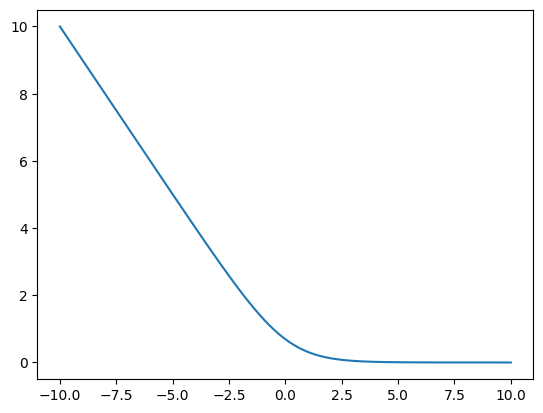

In [0]:
import matplotlib.pyplot as plt


plt.plot(torch.linspace(-10, 10, 1000), -torch.log(torch.sigmoid(torch.linspace(-10, 10, 1000))))



In [0]:
class RewardModel(torch.nn.Module):
  def __init__(self, tokens_sz, ctx_sz, emb_sz, head_sz, device):
    super().__init__()
    ctx_sz += 1

    self.tok_emb = torch.nn.Embedding(tokens_sz, emb_sz, device=device)
    self.pos_emb = torch.nn.Embedding(ctx_sz, emb_sz, device=device)
    self.pos_idx = torch.arange(ctx_sz, device=device)

    self.kw = torch.nn.Linear(emb_sz, head_sz, device=device, bias=False)
    self.qw = torch.nn.Linear(emb_sz, head_sz, device=device, bias=False)
    self.vw = torch.nn.Linear(emb_sz, head_sz, device=device, bias=False)
    self.mhsa = torch.nn.MultiheadAttention(head_sz, 2, batch_first=True, device=device)
    self.mhsa_ln = torch.nn.LayerNorm(head_sz, device=device)
    self.flatten = torch.nn.Flatten(1)
    self.relu = torch.nn.ReLU()
    self.mhsa_head = torch.nn.Linear(head_sz * ctx_sz, tokens_sz, device=device)
    self.logistic_output = torch.nn.Linear(tokens_sz, 1, device=device)  # Add a new linear layer for binary output

  def forward(self, x):
      x = self.tok_emb(x) + self.pos_emb(self.pos_idx)
      q, k, v = self.qw(x), self.kw(x), self.vw(x)
      x, _ = self.mhsa(q, k, v, )
      x = self.mhsa_ln(x)
      x = self.flatten(x)
      x = self.relu(x)
      x = self.mhsa_head(x)
      x = self.logistic_output(x)  # Apply sigmoid to get the binary output
      return torch.sigmoid(x)


EMBEDDING_SIZE = 64
MULTI_HEAD_ATTENTION_SIZE = 64

      
# Custom Bradley Terry Loss
class CustomLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, y1, y2):
        return torch.mean(-torch.log(torch.sigmoid(y1 - y2)))


rm = RewardModel(len(tokens), WINDOW_LENGTH, EMBEDDING_SIZE, MULTI_HEAD_ATTENTION_SIZE, device)




In [0]:
  y1 = rm(torch.stack([stot(pairwise_data[i][0]).argmax(-1) for i in range(len(pairwise_data))]).long().to(device))
  y2 = rm(torch.stack([stot(pairwise_data[i][1]).argmax(-1) for i in range(len(pairwise_data))]).long().to(device))

  sum(torch.flatten(y1>y2)) / len(y1)

tensor(0.6720, device='cuda:0')

In [0]:

criterion = CustomLoss()  
optim = torch.optim.AdamW(rm.parameters())

num_epochs = 50

for epoch in range(num_epochs):

  y1 = rm(torch.stack([stot(pairwise_data[i][0]).argmax(-1) for i in range(len(pairwise_data))]).long().to(device))
  y2 = rm(torch.stack([stot(pairwise_data[i][1]).argmax(-1) for i in range(len(pairwise_data))]).long().to(device))


  # # Compute the loss
  loss = criterion(y1, y2)

  # Backward pass and optimization
  
  loss.backward()
  optim.step()
  optim.zero_grad()

  # Print the loss every few epochs
  if (epoch + 1) % 5 == 0:
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [5/50], Loss: 0.5258
Epoch [10/50], Loss: 0.4616
Epoch [15/50], Loss: 0.4577
Epoch [20/50], Loss: 0.4557
Epoch [25/50], Loss: 0.4545
Epoch [30/50], Loss: 0.4539
Epoch [35/50], Loss: 0.4537
Epoch [40/50], Loss: 0.4535
Epoch [45/50], Loss: 0.4534
Epoch [50/50], Loss: 0.4534


In [0]:
  y1 = rm(torch.stack([stot(pairwise_data[i][0]).argmax(-1) for i in range(len(pairwise_data))]).long().to(device))
  y2 = rm(torch.stack([stot(pairwise_data[i][1]).argmax(-1) for i in range(len(pairwise_data))]).long().to(device))

  sum(torch.flatten(y1>y2)) / len(y1)

tensor(0.9943, device='cuda:0')

## Part 3: Train a policy gradient model to align the language model with your preferences

In [0]:


state_action_pairs = [states[i] + actions[i] for i in range(len(states))]
rewards = rm(torch.stack([stot(pair).argmax(-1) for pair in state_action_pairs]).long().to(device)).to(device)

states_vector = torch.stack([stot(state).argmax(-1) for state in states]).long().to(device)
actions_vector = torch.stack([stot(action).argmax(-1) for action in actions]).long().to(device)

In [0]:
print(state_action_pairs[0:10])
print(rewards[0:10])


['^^^^^t', '^^^^ti', '^^^tim', '^^time', '^time$', '^^^^^s', '^^^^si', '^^^sit', '^^site', '^site$']
tensor([[1.1073e-04],
        [1.2602e-04],
        [6.5515e-01],
        [9.9982e-01],
        [9.9997e-01],
        [1.0548e-04],
        [1.4360e-04],
        [7.3108e-01],
        [9.9988e-01],
        [9.9996e-01]], device='cuda:0', grad_fn=<SliceBackward0>)


In [0]:
import copy
policy_gradient_nn = copy.deepcopy(model)

policy_gradient_optim = torch.optim.AdamW(policy_gradient_nn.parameters())
policy_gradient_optim.zero_grad()

In [0]:

print(f"samples from lm")

gen_samples(policy_gradient_nn)

for step in range(10):
  rewards = rm(torch.stack([stot(pair).argmax(-1) for pair in state_action_pairs]).long().to(device)).to(device)
  states_vector = torch.stack([stot(state).argmax(-1) for state in states]).long().to(device)
  actions_vector = torch.stack([stot(action).argmax(-1) for action in actions]).long().to(device)

  logits = policy_gradient_nn(states_vector)

  log_prob_dist = torch.nn.functional.log_softmax(logits, -1)
  log_probs = log_prob_dist[torch.arange(len(actions_vector)), actions_vector]

  #policy gradient
  loss = -(rewards * log_probs).mean() * 1e-8 # low learning rate to make the algorithm stable


  loss.backward()
  policy_gradient_optim.step()
  policy_gradient_optim.zero_grad()

  print()
  print(f"STEP: {step}")
  gen_samples(policy_gradient_nn) 

samples from lm
samples:  ['ptymeutments', 'tudivery', 'fourt', 'calling', 'diabor', 'bulles', 'crins', 'miltan', 'ahictd', 'gating', 'taucktlians', 'acceing', 'hargog', 'homelo', 'lix', 'enemine', 'alestate', 'lolled', 'kiche', 'cub']
avg word length:  6.713
num valid english words (out of 1000): 90

STEP: 0
samples:  ['neek', 'sminder', 'tasel', 'diag', 'sirm', 'tramaging', 'caread', 'steeved', 'alb', 'gook', 'brisons', 'robs', 'buttansh', 'stated', 'home', 'sandbance', 'pens', 'pensexuasumptio', 'proces', 'sovers']
avg word length:  6.649
num valid english words (out of 1000): 94

STEP: 1
samples:  ['enerating', 'desited', 'reprintality', 'solumssy', 'morc', 'cont', 'oppanc', 'surtime', 'mov', 'plantly', 'breeldlake', 'sarriemis', 'treat', 'fortion', 'dring', 'clistial', 'speegra', 'bst', 'struve', 'begense']
avg word length:  6.371
num valid english words (out of 1000): 125

STEP: 2
samples:  ['sitorated', 'pay', 'hosting', 'phanu', 'wit', 'plotor', 'cations', 'drands', 'dighas', '

## Part 4: Train a proximal policy optimisation model to align the language model with your preferences

In [0]:
rl_model = copy.deepcopy(model)
ref_model = copy.deepcopy(model)

rl_optim = torch.optim.Adam(rl_model.parameters())
rl_optim.zero_grad()

In [0]:


for step in range(15):
  rewards = rm(torch.stack([stot(pair).argmax(-1) for pair in state_action_pairs]).long().to(device)).to(device)
  states_vector = torch.stack([stot(state).argmax(-1) for state in states]).long().to(device)
  actions_vector = torch.stack([stot(action).argmax(-1) for action in actions]).long().to(device)


  logits = rl_model(states_vector)
  log_probs = torch.nn.functional.log_softmax(logits, -1)[torch.arange(len(actions_vector)), actions_vector]

  with torch.no_grad():
    ref_log_probs = torch.nn.functional.log_softmax(ref_model(states_vector), -1)[torch.arange(len(actions_vector)), actions_vector]

  ratio = log_probs - ref_log_probs
  ratio = ratio.exp()

  ppo_loss1 = rewards * ratio
  ppo_loss2 = rewards * torch.clamp(ratio, .8, 1.2)

  loss = -torch.min(ppo_loss1, ppo_loss2).mean()

  #policy gradient
  loss = -(rewards * log_probs).mean() * 1e-8

  gen_samples(rl_model) 

  loss.backward()
  rl_optim.step()
  rl_optim.zero_grad()

samples:  ['siderights', 'portinual', 'salveres', 'proce', 'ailtandablence', 'part', 'rake', 'achuage', 'sald', 'happting', 'genums', 'mati', 'involve', 'demonsion', 'afft', 'regory', 'uttack', 'lema', 'ner', 'neeptopo']
avg word length:  6.634
num valid english words (out of 1000): 112
samples:  ['dovols', 'goderaile', 'chineshing', 'structoors', 'pavillanda', 'incousesssbuhed', 'medriolsor', 'holving', 'libre', 'recerves', 'beaccivition', 'baus', 'futs', 'gongsten', 'ponshing', 'lid', 'subscrretion', 'assications', 'call', 'pspecian']
avg word length:  6.581
num valid english words (out of 1000): 112
samples:  ['cabylactor', 'turna', 'bunger', 'prove', 'transh', 'nowte', 'hunced', 'tub', 'unsp', 'earling', 'rese', 'promaty', 'explor', 'finner', 'brang', 'ben', 'reveluding', 'coller', 'compos', 'site']
avg word length:  6.317
num valid english words (out of 1000): 117
samples:  ['tocelly', 'mus', 'heasplices', 'inn', 'carely', 'annon', 'schelds', 'delection', 'cootherbburaws', 'now', 